In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import joblib
import pickle
import time
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Loading data

We have to use pickle here, because save csv adds quotation marks to tokens, which causes the w2v model fail to work.

In [4]:
df=pd.read_pickle('Data/data_cleaned_1')

In [5]:
df

,score,text
0,3.0,"[good, helpfull, read, book, good, type, thats..."
1,1.0,"[sadly, overprice, irrelevant, spite, claim, i..."
2,2.0,"[endless, rant, howard, borrow, dennis, miller..."
3,1.0,"[not, quite, hip, really, shame, time, reserch..."
4,5.0,"[journey, centre, earth, hey, great, book, abs..."
...,...,...
49995,5.0,"[star, short, easy, explanation, follow, lot, ..."
49996,5.0,"[michael, hague, illustration, best, buy, love..."
49997,5.0,"[quot, american, beauty, quot, novel, dark, co..."
49998,4.0,"[funny, quirky, really, funny, witty, book, su..."


## Comment on w2v model vs d2v model

We have started with trying out both w2v and d2v models, and comparing their performance with fixed classification models with the same parameters. The code for the d2v model can be found in Hailey's folder.
After comparison, we decided that w2v works better, so we perform the hyperparameter tuning on the w2v model and also on the classification model with inputs from a w2v model.

## Fit the w2v model

Here we try to get the w2v model to work on dataset.

Define some parameters for a w2v model and fit our data set into the model.

In [6]:
vector_size=1000
#The number of dimensions of embeddings, the default is 100
window=3
#The maximum distance between a target word and its neighbours, default is 5
min_count=3
#The minimum counts of words in order for the word to be considered for the training of model, default is 5
workers=3
#The number of partitions during training, default is 3
sg=1
#The training algorithom, either CBOW(0) or skip gram(1), default is CBOW

#tokens = pd.Series(df['tokenized_text']).values
start_t = time.time()
w2vmodel=Word2Vec(df['text'],min_count=min_count,vector_size=vector_size,workers=workers,sg=sg)
print('Time taken to train word2vec model:' +str(time.time()-start_t))

Time taken to train word2vec model:152.95151329040527


In [7]:
word2vec_model_file = '/Users/xin/Library/CloudStorage/OneDrive-UniversityofBristol/DST/DST_Assessment2/Xin/Data/' + 'word2vec_1' + '.model'
w2vmodel.save(word2vec_model_file)

In [8]:
w2v_model = Word2Vec.load(word2vec_model_file) 
#we have to save and load for some of the function below to work

## Extract the outputs of w2v model

https://towardsdatascience.com/word2vec-explained-49c52b4ccb71

how to put the outputs of word2vec into data frame, and apply PCA on the outputs

In [9]:
emb_df = (
    pd.DataFrame(
        [w2v_model.wv.get_vector(str(n)) for n in w2vmodel.wv.key_to_index],
        index = w2vmodel.wv.key_to_index
    )
)
print(emb_df.shape)

emb_df.head()

(36738, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
book,0.142134,0.001817,-0.001977,0.039095,-0.185617,0.036362,-0.040894,0.058333,-0.097108,-0.024271,...,-0.067489,-0.048330,0.042931,0.073105,0.131919,-0.140548,-0.136153,-0.087357,0.074306,-0.090644
not,0.127618,0.003186,0.022336,0.070933,-0.048592,-0.033276,-0.033415,0.046059,-0.042061,-0.016839,...,-0.099129,-0.058760,0.046065,0.098410,0.009373,-0.149313,-0.095472,-0.057078,-0.032968,-0.129977
read,0.152725,-0.039679,-0.007645,0.138506,-0.139321,0.088341,0.065927,0.126205,-0.105629,-0.114903,...,0.024554,0.041556,-0.055108,0.017347,0.064832,0.070416,-0.160607,-0.284233,-0.007708,-0.123880
one,0.094242,0.110338,0.012368,0.011178,-0.148854,-0.082454,0.125944,0.058808,-0.169197,-0.056303,...,-0.002211,0.086618,0.044833,0.075094,0.039257,-0.110331,-0.023858,-0.241639,0.022365,-0.087534
story,0.046940,-0.027180,0.004206,0.081102,-0.121405,-0.030946,0.004722,-0.025572,-0.097799,0.050827,...,0.046225,0.029135,0.047138,-0.116216,0.181516,0.059388,-0.076943,-0.100316,0.122159,-0.095791


In [10]:
print(w2v_model.wv.most_similar('wonderful'))

[('wonderfull', 0.6725864410400391), ('splendid', 0.6579285264015198), ('fabulous', 0.6503364443778992), ('marvelous', 0.6404098868370056), ('nesbit', 0.628792941570282), ('tasteful', 0.6281416416168213), ('kingsbury', 0.6256381869316101), ('fantastic', 0.6237612962722778), ('exellent', 0.6178607940673828), ('kaye', 0.6163508296012878)]


In [11]:
print("Cosine similarity between 'wonderful' " +
               "terrible' - Skip Gram : ",
    w2v_model.wv.similarity('wonderful', 'bad'))

Cosine similarity between 'wonderful' terrible' - Skip Gram :  0.24212708


[]

<Figure size 640x480 with 0 Axes>

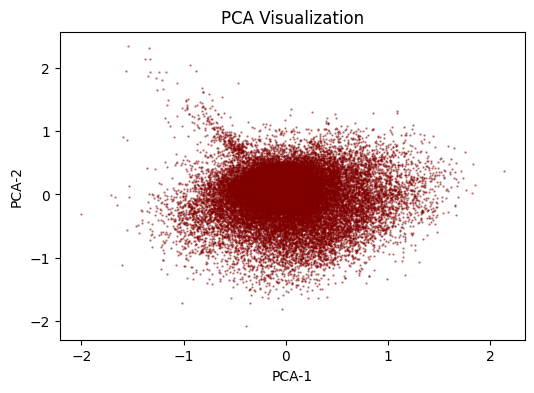

In [12]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)

plt.clf()
fig = plt.figure(figsize=(6,4))

plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

## Train test data split

In [13]:
def split_train_test(df, test_size=0.2, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df['text'], 
                                                        df['score'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

In [14]:
X_train, X_test, y_train, y_test = split_train_test(df)

Value counts for Train sentiments
5.0    24226
4.0     7728
3.0     3422
1.0     2638
2.0     1986
Name: score, dtype: int64
Value counts for Test sentiments
5.0    6042
4.0    1963
3.0     854
1.0     639
2.0     502
Name: score, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                               text
0  45570  [multidimensional, thought, book, good, job, p...
1  21855  [magnetic, influence, success, business, find,...
2  41127  [read, weep, world, full, bad, book, write, am...
3   4849  [clear, channel, watt, book, great, show, book...
4  20742  [page, miss, line, mass, market, paperback, ed...


In [15]:
X_train.to_pickle('Data/X_train')
X_test.to_pickle('Data/X_test')
y_train.to_pickle('Data/y_train')
y_test.to_pickle('Data/y_test')

In [16]:
X_train=pd.read_pickle('Data/X_train')
X_test=pd.read_pickle('Data/X_test')
y_train=pd.read_pickle('Data/y_train')
y_test=pd.read_pickle('Data/y_test')

## Compute feature vectors for each review
https://www.kaggle.com/code/varun08/sentiment-analysis-using-word2vec/notebook
 define functions to compute feature vectors, which is an average of the vectors of each word appeared in the review, and the feature vectors can be then be used as inputs for the classification model.

In [17]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index_to_key)
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
    
    if nwords ==0:
        featureVec = np.zeros(1000)
        #avoiding divide by zero, define it as a all zero vector
    else:
        featureVec = np.divide(featureVec, nwords)
    # Dividing the result by number of words to get average

    return featureVec

In [18]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Comment %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
            
        counter = counter+1
        
    return reviewFeatureVecs

## Classification models

In this section, we train two classification models random forest and xgboost on our train data, we want to compare the their performance on a test data set latter.

In [19]:
trainDataVecs = getAvgFeatureVecs(X_train['text'], w2v_model, 1000)
#get feature vectors for train data

Comment 0 of 40000
Comment 1000 of 40000
Comment 2000 of 40000
Comment 3000 of 40000
Comment 4000 of 40000
Comment 5000 of 40000
Comment 6000 of 40000
Comment 7000 of 40000
Comment 8000 of 40000
Comment 9000 of 40000
Comment 10000 of 40000
Comment 11000 of 40000
Comment 12000 of 40000
Comment 13000 of 40000
Comment 14000 of 40000
Comment 15000 of 40000
Comment 16000 of 40000
Comment 17000 of 40000
Comment 18000 of 40000
Comment 19000 of 40000
Comment 20000 of 40000
Comment 21000 of 40000
Comment 22000 of 40000
Comment 23000 of 40000
Comment 24000 of 40000
Comment 25000 of 40000
Comment 26000 of 40000
Comment 27000 of 40000
Comment 28000 of 40000
Comment 29000 of 40000
Comment 30000 of 40000
Comment 31000 of 40000
Comment 32000 of 40000
Comment 33000 of 40000
Comment 34000 of 40000
Comment 35000 of 40000
Comment 36000 of 40000
Comment 37000 of 40000
Comment 38000 of 40000
Comment 39000 of 40000


In [20]:
trainDataVecs.dump('Data/trainDataVecs')

In [21]:
trainDataVecs=pd.read_pickle('Data/trainDataVecs')

In [22]:
def remove_unuseful_rows(trainDataVecs,y_train):
    list=[]
    y_train.reset_index()
    for i in range(trainDataVecs.shape[0]):
        if np.all(trainDataVecs[i,]==0):
            list.append(i)
    if len(list)!=0:
        trainDataVecs=np.delete(trainDataVecs,list,axis=0)
        y_train.drop(index=list,inplace=True)
    return trainDataVecs,y_train
# remove the sample with all zero vector and its corresponding y

In [23]:
trainDataVecs1,y_train1=remove_unuseful_rows(trainDataVecs,y_train)

In [24]:
y_train1.shape

(39999, 2)

In [25]:
trainDataVecs1.shape

(39999, 1000)

We only want to classify if the review is good or bad, here I create a new label 'sentiment', it equals to 0 if the review is bad(i.e. the raing is less or equals to 3), and equals to 1 otherwise.

In [26]:
y_train1['sentiment'] = 0

In [27]:
y_train1=y_train1.reset_index(drop=True)

In [28]:
for i in range(y_train1.shape[0]):
    if y_train1['score'][i] > 3:
        y_train1['sentiment'][i] = 1

/var/folders/0s/xfpwvv6x0fg3pkqm99zxr6z40000gq/T/ipykernel_7551/2132215972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train1['sentiment'][i] = 1


## Classification models

In this section, we train two classification models random forest and xgboost on our train data, we want to compare the their performance on a test data set latter.

In [29]:
xgb_model = xgb.XGBClassifier(
    max_depth = 9, 
    min_child_weight = 1, 
    gamma = 0.4, 
    subsample=0.9, 
    colsample_bytree = 0.9,
    learning_rate =0.2,
    n_estimators=300)


start_time = time.time()
xgb_model.fit(trainDataVecs1, y_train1["sentiment"])
print("Time taken to fit the demodel with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the demodel with word2vec vectors: 516.587042093277


In [30]:
filename='xgb_model1.joblib'
joblib.dump(xgb_model,filename)

['xgb_model1.joblib']

In [31]:
xgb_model=joblib.load('xgb_model1.joblib')

In [41]:
forest = RandomForestClassifier(n_estimators = 100)

start_time = time.time()
# Fit the model
forest = forest.fit(trainDataVecs1, y_train1["sentiment"])
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 97.03414297103882


In [42]:
filename='forest_model1.joblib'
joblib.dump(forest,filename)

['forest_model1.joblib']

In [43]:
forest=joblib.load('forest_model1.joblib')

## Test data set

We start with process the test data set just like we did for the train data, i.e. compute feature vectors, remove rows that divide by zero, and etc.

In [34]:
testDataVecs = getAvgFeatureVecs(X_test['text'], w2v_model, 1000)

Comment 0 of 10000
Comment 1000 of 10000
Comment 2000 of 10000
Comment 3000 of 10000
Comment 4000 of 10000
Comment 5000 of 10000
Comment 6000 of 10000
Comment 7000 of 10000
Comment 8000 of 10000
Comment 9000 of 10000


In [35]:
y_test=y_test.reset_index(drop=True)

In [36]:
testDataVecs1,y_test1=remove_unuseful_rows(testDataVecs,y_test)

In [37]:
y_test1['sentiment']=0
for i in range(y_test1.shape[0]):
    if y_test1['score'][i] > 3:
        y_test1['sentiment'][i] = 1

/var/folders/0s/xfpwvv6x0fg3pkqm99zxr6z40000gq/T/ipykernel_7551/1742227497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test1['sentiment'][i] = 1


In [44]:
forest_prediction=forest.predict(testDataVecs1)

In [45]:
np.dot(forest_prediction-y_test1['sentiment'],forest_prediction-y_test1['sentiment'])

1556

In [46]:
print(classification_report(y_test1['sentiment'],forest_prediction))

              precision    recall  f1-score   support

           0       0.80      0.30      0.43      1995
           1       0.85      0.98      0.91      8005

    accuracy                           0.84     10000
   macro avg       0.82      0.64      0.67     10000
weighted avg       0.84      0.84      0.81     10000



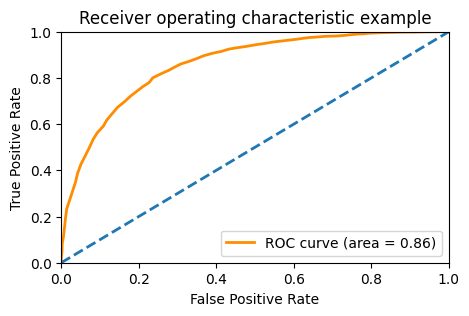

In [47]:
y_pred = [x[1] for x in forest.predict_proba(testDataVecs1)]
fpr, tpr, thresholds = roc_curve(y_test1['sentiment'], y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [48]:
xgb_prediction=xgb_model.predict(testDataVecs1)

In [39]:
np.dot(xgb_prediction-y_test1['sentiment'],xgb_prediction-y_test1['sentiment'])

1289

In [40]:
print(classification_report(y_test1['sentiment'],xgb_prediction))

              precision    recall  f1-score   support

           0       0.77      0.51      0.61      1995
           1       0.89      0.96      0.92      8005

    accuracy                           0.87     10000
   macro avg       0.83      0.74      0.77     10000
weighted avg       0.86      0.87      0.86     10000



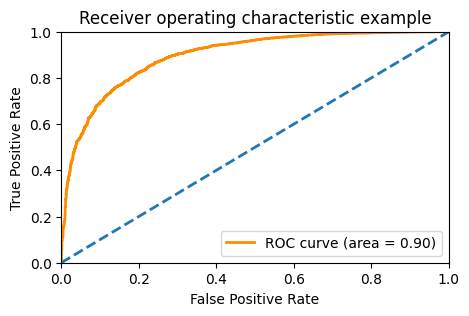

In [52]:
y_pred = [x[1] for x in xgb_model.predict_proba(testDataVecs1)]
fpr, tpr, thresholds = roc_curve(y_test1['sentiment'], y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

All the metrics that I used above suggests that xgboost works better with the w2v model on our data set than the random forest.

## XGB with weights

In [58]:
scale_pos_weight = (sum(y_train1['sentiment']==0))/(sum(y_train1['sentiment']==1))
print(scale_pos_weight)

0.2518073420336119


In [59]:
xgb_weighted = xgb.XGBClassifier(
    max_depth = 9, 
    min_child_weight = 1, 
    gamma = 0.4, 
    subsample = 0.9, 
    colsample_bytree = 0.9,
    learning_rate = 0.2,
    n_estimators = 300,
    scale_pos_weight = scale_pos_weight,
    eval_metric='logloss')


start_time = time.time()
xgb_weighted.fit(trainDataVecs1, y_train1["sentiment"])
print("Time taken to train the model: " + str(time.time() - start_time))

Time taken to train the model: 540.5646269321442


In [60]:
filename='xgb_model_weighted.joblib'
joblib.dump(xgb_weighted,filename)

['xgb_model_weighted.joblib']

In [61]:
xgb_weighted=joblib.load('xgb_model_weighted.joblib')

In [62]:
xgb_weighted_prediction=xgb_weighted.predict(testDataVecs1)

In [63]:
np.dot(xgb_weighted_prediction-y_test1['sentiment'],xgb_weighted_prediction-y_test1['sentiment'])

1329

In [64]:
print(classification_report(y_test1['sentiment'],xgb_weighted_prediction))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      1995
           1       0.90      0.94      0.92      8005

    accuracy                           0.87     10000
   macro avg       0.80      0.76      0.78     10000
weighted avg       0.86      0.87      0.86     10000



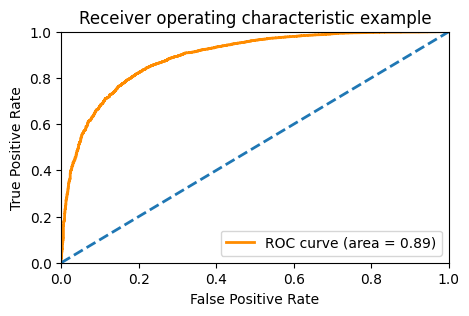

In [65]:
y_pred = [x[1] for x in xgb_weighted.predict_proba(testDataVecs1)]
fpr, tpr, thresholds = roc_curve(y_test1['sentiment'], y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Grid Search

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

In [53]:
#params = deepcopy(default_params)

param_grid = {
        'min_child_weight': [5,10],
        'max_depth': [7,9]
        }

# just for checking if grid search works

In [55]:
estimator = xgb.XGBClassifier(n_estimators=300, objective='binary:logistic',learning_rate =0.2, 
    subsample=0.9, gamma = 0.4,
    colsample_bytree = 0.9,)

In [56]:
eval_set = [(trainDataVecs1,y_train1['sentiment'].values)]
model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, scoring="roc_auc")

start_time = time.time()

model.fit(trainDataVecs1,y_train1['sentiment'].values, verbose=0)

print("Time taken for grid search: " + str(time.time() - start_time))

Time taken for grid search: 3800.184249162674


In [57]:
print(model.best_params_)

{'max_depth': 9, 'min_child_weight': 10}


### Random Search
We perform the random search on the small data set, and then use the best parameters for the 200k data set later, this is due to time constraint and the ranadom search is slow. We also change n_estimator from 300 to 200, try to speed up the process.

In [ ]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.9],
        'colsample_bytree': [0.6, 0.9],
        'max_depth': [5,10,15]
        }

In [ ]:
estimator = xgb.XGBClassifier(n_estimators=300, objective='binary:logistic',learning_rate =0.2)

In [ ]:
rs_model=RandomizedSearchCV(estimator=estimator,param_distributions=param_grid,n_iter=3,scoring='logloss',n_jobs=-1,cv=3,verbose=3)

In [ ]:
rs_model.fit(trainDataVecs1,y_train1['sentiment'])

In [ ]:
rs_model.best_params_

https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search

Due to the size of the data set and the time constraint, since we want to search over a large range of hyperparameters rather than finding an exact optima in a small range of hyperprarameters, we will perform a random search on a subset of the data set, and then tuning our hyperparameters for working on the whole data set.

If we have more time, we can then perform grid search on a reduced parameter grid, in order to get better performance.